## Import and Read Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext google.colab.data_table
%matplotlib inline

In [3]:
import os
os.getcwd()
os.listdir()
#chuyển về thư mục data bên trong Google Drive.
os.chdir('/content/drive/MyDrive/VEF/ML/Final Project/Dataset')
os.getcwd()
os.listdir()

['HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'sample_submission.csv',
 'previous_application.csv']

# Columns Description

In [4]:
cols_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859–1', engine='python')
cols_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


#Process Function

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
        
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
        
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
        
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
        
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
        
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
        
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
        
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    dropcolum=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
    df= df.drop(dropcolum,axis=1)
    del test_df
    gc.collect()
    return df

In [8]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [9]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [10]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [11]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min','std' ],
        'DBD': ['max', 'mean', 'sum','min','std'],
        'PAYMENT_PERC': [ 'max','mean',  'var','min','std'],
        'PAYMENT_DIFF': [ 'max','mean', 'var','min','std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min','std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum','std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','std']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [12]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [13]:
df = application_train_test()
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance()
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications()
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash()
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments()
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance()
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 95)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 219)
Process previous_applications - done in 23s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 12s
Installments payments df shape: (339587, 36)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 17s


In [14]:
df.shape

(356251, 721)

In [15]:
df.head(2)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,...,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Read in Data

In [16]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
print('Training data shape : ', app_train.shape)
print('Testing data shape : ', app_test.shape)

Training data shape :  (307511, 122)
Testing data shape :  (48744, 121)


In [17]:
pos_cash_bal = pd.read_csv("POS_CASH_balance.csv")
bureau_bal = pd.read_csv("bureau_balance.csv")
bureau = pd.read_csv("bureau.csv")
installment_payment = pd.read_csv("installments_payments.csv")
credit_card_bal = pd.read_csv("credit_card_balance.csv")

In [18]:
previous_app = pd.read_csv("previous_application.csv")

# Data Description

In [ ]:
type(app_train)

pandas.core.frame.DataFrame

In [ ]:
# %reload_ext  google.colab.data_table
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
pos_cash_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
installment_payment.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
credit_card_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
app_train['SK_ID_CURR'].isnull().sum()

0

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
credit_card_bal[credit_card_bal.SK_ID_CURR == 186401]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
10956,2243411,186401,-3,0.000,0,0.0,0.0,0.0,0.0,0.0,472.860,0.0,0.00,0.000,0.000,0.0,0,0.0,0.0,64.0,Active,0,0
40458,1440617,186401,-38,0.000,112500,0.0,0.0,0.0,0.0,0.0,228.915,0.0,0.00,0.000,0.000,0.0,0,0.0,0.0,51.0,Active,0,0
78582,1440617,186401,-8,0.000,112500,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.000,0.000,0.0,0,0.0,0.0,51.0,Completed,0,0
138926,2243411,186401,-41,182695.680,180000,0.0,0.0,0.0,0.0,9000.0,9000.000,9000.0,177058.80,182695.680,182695.680,0.0,0,0.0,0.0,55.0,Active,0,0
157718,2243411,186401,-23,0.000,180000,0.0,0.0,0.0,0.0,0.0,472.860,0.0,0.00,0.000,0.000,0.0,0,0.0,0.0,64.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755437,2243411,186401,-76,184542.075,180000,4500.0,4500.0,0.0,0.0,9000.0,9000.000,9000.0,177804.09,184542.075,184542.075,2.0,2,0.0,0.0,20.0,Active,1,1
3782341,2243411,186401,-40,183063.240,180000,2700.0,2700.0,0.0,0.0,9000.0,9000.000,9000.0,176395.68,183063.240,183063.240,1.0,1,0.0,0.0,56.0,Active,0,0
3813465,2243411,186401,-46,180173.970,180000,2025.0,2025.0,0.0,0.0,9000.0,9000.000,9000.0,172365.12,180173.970,180173.970,2.0,2,0.0,0.0,50.0,Active,0,0
3823260,2243411,186401,-7,0.000,0,0.0,0.0,0.0,0.0,0.0,472.860,0.0,0.00,0.000,0.000,0.0,0,0.0,0.0,64.0,Active,0,0


In [ ]:
installment_payment[installment_payment.SK_ID_CURR == 186401]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
4191,2243411,186401,0.0,26,-2157.0,-2180.0,9000.000,9000.000
6680,2704200,186401,1.0,5,-878.0,-886.0,39386.250,39386.250
32384,2704200,186401,1.0,10,-728.0,-732.0,39386.250,39386.250
34497,2717650,186401,2.0,2,-1337.0,-1397.0,13779.405,13779.405
45195,2243411,186401,0.0,68,-969.0,-999.0,181.395,181.395
...,...,...,...,...,...,...,...,...
3713865,2243411,186401,0.0,98,-116.0,-116.0,472.860,472.860
3726271,2243411,186401,0.0,5,-2765.0,-2789.0,9000.000,9000.000
3777886,2704200,186401,1.0,23,-338.0,-364.0,39386.250,39386.250
3790881,2243411,186401,0.0,83,-572.0,-572.0,472.860,472.860


In [ ]:
pos_cash_bal[pos_cash_bal.SK_ID_CURR == 186401]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
141317,2704200,186401,-23,60.0,49.0,Active,0,0
523786,2704200,186401,-11,60.0,37.0,Active,0,0
542392,2718006,186401,-20,12.0,7.0,Active,0,0
579250,2704200,186401,-26,60.0,52.0,Active,0,0
686915,2718006,186401,-18,12.0,5.0,Active,0,0
...,...,...,...,...,...,...,...,...
9214860,1363854,186401,-49,24.0,23.0,Active,0,0
9325738,2718006,186401,-17,12.0,4.0,Active,0,0
9408967,1363854,186401,-42,24.0,16.0,Active,0,0
9527639,1363854,186401,-48,24.0,22.0,Active,0,0


In [ ]:
bureau[bureau.SK_ID_CURR == 186401]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
347679,186401,6090361,Closed,currency 1,-1617,0,-521.0,-1470.0,NaN,0,225000.0,0.0,0.0,0.0,Consumer credit,-1138,NaN
558345,186401,6090360,Closed,currency 1,-610,0,-266.0,-229.0,NaN,0,1125000.0,0.0,0.0,0.0,Credit card,-219,NaN
558346,186401,6090362,Closed,currency 1,-1320,0,-770.0,-1147.0,NaN,0,90000.0,0.0,0.0,0.0,Consumer credit,-1138,NaN
558347,186401,6090363,Active,currency 1,-701,0,1106.0,NaN,NaN,0,729000.0,514912.5,0.0,0.0,Consumer credit,-48,NaN
558348,186401,6090364,Active,currency 1,-310,0,3386.0,NaN,NaN,0,1125000.0,1116283.5,0.0,0.0,Credit card,-16,NaN
558349,186401,6090365,Closed,currency 1,-1936,0,-1696.0,-1138.0,NaN,0,61569.0,NaN,NaN,0.0,Consumer credit,-1135,NaN
558350,186401,6090366,Closed,currency 1,-1268,0,-1025.0,-970.0,NaN,0,360000.0,NaN,NaN,0.0,Consumer credit,-967,NaN
558351,186401,6090367,Closed,currency 1,-1472,0,354.0,-699.0,NaN,0,585000.0,NaN,NaN,0.0,Consumer credit,-696,0.0
558352,186401,6090368,Active,currency 1,-364,0,1462.0,NaN,NaN,0,1336500.0,NaN,NaN,0.0,Consumer credit,-24,223393.5
558353,186401,6090369,Active,currency 1,-267,0,3386.0,NaN,NaN,0,1125000.0,1116283.5,NaN,0.0,Credit card,-19,75195.0


In [ ]:
bureau_bal[bureau_bal.SK_ID_BUREAU == 6273096	]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
12163019,6273096,0,0
12163020,6273096,-1,0
12163021,6273096,-2,0
12163022,6273096,-3,0
12163023,6273096,-4,0
...,...,...,...
12163104,6273096,-85,0
12163105,6273096,-86,0
12163106,6273096,-87,0
12163107,6273096,-88,0


# EDA

### Missing values

In [19]:
def create_table_missing_values(df):
    mis_val = df.isnull().sum() #total missing values #input: df MxN -> output: df Nx2
    mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values #input: df MxN -> output: df Nx2
    mis_val_table = pd.concat( #join df mis_val and df mis_val_percent
        [mis_val, mis_val_percent], 
        axis=1
        ) 
    mis_val_table_ren_columns = mis_val_table.rename( #rename the columns
        columns = {
            0 : 'Missing values', 
            1 : '% of Total Values'
            }
        )
    mis_val_table_ren_columns = mis_val_table_ren_columns[ #sort the table by percentage of missing descending
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1) #exclude those has 0% missing
  
    print("Your selected dataframe has ")    
    return mis_val_table_ren_columns

In [20]:
create_table_missing_values=create_table_missing_values(df)
create_table_missing_values

Your selected dataframe has 


,Missing values,% of Total Values
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.2
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.9
...,...,...
NEW_ANNUITY_TO_INCOME_RATIO,36,0.0
AMT_ANNUITY,36,0.0
CNT_FAM_MEMBERS,2,0.0
DAYS_LAST_PHONE_CHANGE,1,0.0


In [21]:
lst_drop = create_table_missing_values[create_table_missing_values['% of Total Values']>50].index

In [22]:
df.drop(columns=lst_drop, inplace=True)

In [23]:
df.shape

(356251, 523)

In [24]:
# Với biến chỉ có 2 giá trị, dùng label encoding, nếu nhiều hơn thì chuyển sang encoding rồi dùng one-hot encoding 
# Create a label encoder object
le = LabelEncoder()
le_count = 0
lst_name = []
# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            lst_name.append(col)
            # Keep track of how many columns were label encoded
            le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [25]:
lst_name

['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [26]:
# apply one-hot encoding với các biến đã dùng label encoding, trong pd dùng get_dummies, trong scikit learn là one hot encoding
#one-hot encoding of categorical variables
app_train = pd.get_dummies(df)
print('Training Features shape: ', app_train.shape)


Training Features shape:  (356251, 523)


In [27]:
app_train.dtypes.value_counts()

float64    365
uint8      133
int64       25
dtype: int64

In [28]:
app_train_test = app_train.copy()

In [29]:
app_train_test = app_train_test.dropna()

In [30]:
app_train_test.shape

(37973, 523)

In [ ]:
# app_train_test = app_train_test.astype(dict.fromkeys(app_train_test.select_dtypes('object'), 'category'))

#Correlation

In [32]:
# Create correlation matrix
corr_mat = app_train_test.drop('SK_ID_CURR',axis=1).corr(method='pearson')
# Convert correlation matrix to 1-D Series and sort
sorted_mat = corr_mat.unstack().sort_values()

In [36]:
print(sorted_mat.head(60))

EMERGENCYSTATE_MODE_No                             EMERGENCYSTATE_MODE_Yes                             -1.000000
EMERGENCYSTATE_MODE_Yes                            EMERGENCYSTATE_MODE_No                              -1.000000
NAME_CONTRACT_TYPE_Revolving loans                 NAME_CONTRACT_TYPE_Cash loans                       -1.000000
NAME_CONTRACT_TYPE_Cash loans                      NAME_CONTRACT_TYPE_Revolving loans                  -1.000000
PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN            PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN             -1.000000
PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN            PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN                -1.000000
PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN               PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN             -1.000000
PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN            PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN             -1.000000
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN        PREV_NAME_GOODS_CATEGORY_XNA_MEAN            

In [37]:
# app_train_test.drop('SK_ID_CURR',axis=1).columns[1:]

In [41]:
Lst_correlation = []
def create_table_top_corr(df, target_col_name):
    correlations = df.corr()[target_col_name].sort_values(ascending=True)    
    print('\nMost Negative Correlations:\n', correlations.head(30))    
    Lst_correlation.append(correlations.head(30).index)

In [42]:
df_test = app_train_test.drop('SK_ID_CURR',axis=1)
create_table_top_corr(df_test,'TARGET')


Most Negative Correlations:
 NEW_EXT_SOURCES_MEAN                                       -0.219267
EXT_SOURCE_3                                               -0.159913
EXT_SOURCE_2                                               -0.145630
PREV_NAME_CONTRACT_STATUS_Approved_MEAN                    -0.073545
PREV_CODE_REJECT_REASON_XAP_MEAN                           -0.068467
BURO_CREDIT_ACTIVE_Closed_MEAN                             -0.066473
NAME_EDUCATION_TYPE_Higher education                       -0.059651
NEW_EMPLOY_TO_BIRTH_RATIO                                  -0.057054
PREV_NAME_PORTFOLIO_POS_MEAN                               -0.053112
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN                -0.050694
INSTAL_PAYMENT_PERC_MIN                                    -0.041879
BURO_DAYS_CREDIT_VAR                                       -0.041323
CODE_GENDER                                                -0.040610
NAME_CONTRACT_TYPE_Revolving loans                         -0.040147
PREV

In [43]:
Lst_correlation

[Index(['NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
        'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
        'PREV_CODE_REJECT_REASON_XAP_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN',
        'NAME_EDUCATION_TYPE_Higher education', 'NEW_EMPLOY_TO_BIRTH_RATIO',
        'PREV_NAME_PORTFOLIO_POS_MEAN',
        'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
        'INSTAL_PAYMENT_PERC_MIN', 'BURO_DAYS_CREDIT_VAR', 'CODE_GENDER',
        'NAME_CONTRACT_TYPE_Revolving loans',
        'PREV_NAME_YIELD_GROUP_low_normal_MEAN', 'INSTAL_AMT_PAYMENT_MIN',
        'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
        'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
        'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
        'BURO_CREDIT_TYPE_Mortgage_MEAN',
        'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
        'APPROVED_AMT_ANNUITY_MEAN', 'INSTAL_AMT_INSTALMENT_MIN',
        'AMT_GOODS_PRICE',
        'PREV_NAME_SELLER_INDUSTRY_Con

#T-Test

In [44]:
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr

In [45]:
my_important = []
df = app_train_test.drop('SK_ID_CURR',axis=1)

In [46]:
for c in df.columns[1:]:    
    pvalue = stats.ttest_ind(df.loc[df.TARGET==1][c], df.loc[df.TARGET==0][c])[1]
    if pvalue<0.05:
        my_important.append(c)
        print(f'Variable {c} have pvalue = {pvalue:.2}')
    else:
        print(f'Variable {c} is NOT statistically significant')

Variable TARGET have pvalue = 0.0
Variable CODE_GENDER have pvalue = 2.4e-15
Variable FLAG_OWN_CAR have pvalue = 0.00044
Variable FLAG_OWN_REALTY have pvalue = 0.04
Variable CNT_CHILDREN is NOT statistically significant
Variable AMT_INCOME_TOTAL have pvalue = 0.0016
Variable AMT_CREDIT have pvalue = 2.2e-05
Variable AMT_ANNUITY is NOT statistically significant
Variable AMT_GOODS_PRICE have pvalue = 1.1e-09
Variable REGION_POPULATION_RELATIVE have pvalue = 0.0017
Variable DAYS_BIRTH have pvalue = 3.5e-38
Variable DAYS_EMPLOYED have pvalue = 7.3e-37
Variable DAYS_REGISTRATION have pvalue = 0.0001
Variable DAYS_ID_PUBLISH have pvalue = 3.6e-12
Variable FLAG_MOBIL is NOT statistically significant
Variable FLAG_EMP_PHONE is NOT statistically significant
Variable FLAG_WORK_PHONE is NOT statistically significant
Variable FLAG_CONT_MOBILE is NOT statistically significant
Variable FLAG_PHONE have pvalue = 2e-05
Variable FLAG_EMAIL is NOT statistically significant
Variable CNT_FAM_MEMBERS is NOT

In [47]:
my_important

['TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'NEW_DOC_IND_KURT',
 'NEW_INC_PER_CHLD',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NE

#Random Forest Feature Importance

In [48]:
clf = RandomForestClassifier( n_estimators=50)
X = df.drop(['TARGET'], axis=1)
y = df.TARGET
model = clf.fit(X,y)
feat_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

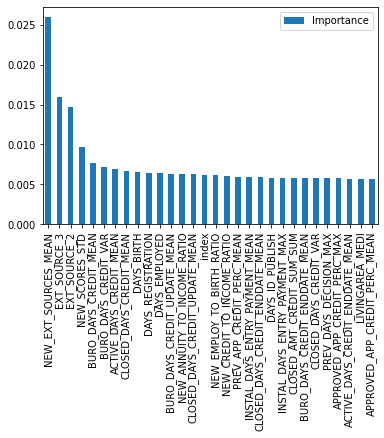

In [54]:
feat_importances.head(30).plot(kind='bar')

In [55]:
feat_importances.head(30)

,Importance
NEW_EXT_SOURCES_MEAN,0.025910
EXT_SOURCE_3,0.015952
EXT_SOURCE_2,0.014706
NEW_SCORES_STD,0.009684
BURO_DAYS_CREDIT_MEAN,0.007642
BURO_DAYS_CREDIT_VAR,0.007132
ACTIVE_DAYS_CREDIT_MEAN,0.006879
CLOSED_DAYS_CREDIT_MEAN,0.006738
DAYS_BIRTH,0.006534
DAYS_REGISTRATION,0.006447


In [56]:
feat_importances.index[0:30]

Index(['NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
       'NEW_SCORES_STD', 'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_VAR',
       'ACTIVE_DAYS_CREDIT_MEAN', 'CLOSED_DAYS_CREDIT_MEAN', 'DAYS_BIRTH',
       'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'BURO_DAYS_CREDIT_UPDATE_MEAN',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
       'index', 'NEW_EMPLOY_TO_BIRTH_RATIO', 'NEW_CREDIT_TO_INCOME_RATIO',
       'PREV_APP_CREDIT_PERC_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'CLOSED_DAYS_CREDIT_ENDDATE_MEAN', 'DAYS_ID_PUBLISH',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'CLOSED_AMT_CREDIT_SUM_SUM',
       'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'CLOSED_DAYS_CREDIT_VAR',
       'PREV_DAYS_DECISION_MAX', 'APPROVED_APP_CREDIT_PERC_MAX',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'LIVINGAREA_MEDI',
       'APPROVED_APP_CREDIT_PERC_MEAN'],
      dtype='object')

#K-Best

In [57]:
X  = df.drop('TARGET',axis=1)
X_pos = df.drop('TARGET',axis=1).abs()
y = df.TARGET

In [58]:
selector = SelectKBest(score_func=chi2, k=30)
new_data = selector.fit_transform(X_pos, y)
mask = selector.get_support()
new_features_k_best = X_pos.columns[mask]
new_features_k_best

Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'BURO_DAYS_CREDIT_VAR',
       'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
       'CLOSED_DAYS_CREDIT_VAR', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'CLOSED_AMT_CREDIT_SUM_SUM', 'APPROVED_AMT_APPLICATION_MAX',
       'APPROVED_AMT_APPLICATION_MEAN', 'APPROVED_AMT_CREDIT_MAX',
       'APPROVED_AMT_CREDIT_MEAN', 'APPROVED_AMT_GOODS_PRICE_MAX',
       'APPROVED_AMT_GOODS_PRICE_MEAN', 'INSTAL_PAYMENT_PERC_VAR',
       'INSTAL_PAYMENT_DIFF_VAR', 'INSTAL_PAYMENT_DIFF_MIN',
       'INSTAL_AMT_INSTALMENT_MAX', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_SUM'],
      dtype=

#FWE

In [59]:
#chi-square
selector = SelectFwe(score_func=chi2, alpha=0.05)
new_data = selector.fit_transform(X_pos, y)
mask = selector.get_support()
new_features_chi_fwe = X_pos.columns[mask]

Index(['index', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH',
       ...
       'INSTAL_AMT_INSTALMENT_MIN', 'INSTAL_AMT_INSTALMENT_STD',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_AMT_PAYMENT_STD', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_STD'],
      dtype='object', length=157)

In [60]:
new_features_chi_fwe[0:30]

Index(['index', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NEW_INC_BY_ORG',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'NEW_DOC_IND_KURT', 'NEW_INC_PER_CHLD',
       'NEW_EXT_SOURCES_MEAN', 'NAME_CONTRACT_TYPE_Revolving loans',
       'NAME_INCOME_TYPE_State servant',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents'],
      dtype='object')

In [61]:
#Anova
selector = SelectFwe(score_func=f_classif, alpha=0.05)
new_data = selector.fit_transform(X, y)
mask = selector.get_support()
new_features_anova_fwe = X.columns[mask]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 14  76  78  82  93 183 219 224 230 232 240 292 300 303 319 329 334 339
 349 362 377 391 397 401 410 422 428 475 477 482 483] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [62]:
new_features_anova_fwe[0:30]

Index(['CODE_GENDER', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_PHONE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
       'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_DOC_IND_KURT',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'NEW_EXT_SOURCES_MEAN', 'NEW_SCORES_STD',
       'NEW_PHONE_TO_BIRTH_RATIO'],
      dtype='object')

#FDR

In [63]:
selector = SelectFdr(chi2, alpha=0.05)
new_data = selector.fit_transform(X_pos, y)
mask = selector.get_support()
new_features_FDR = X.columns[mask]

In [64]:
new_features_FDR[0:30]

Index(['index', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_PHONE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NEW_INC_BY_ORG',
       'NEW_CREDIT_TO_ANNUITY_RATIO'],
      dtype='object')

#SUMMARY FEATURE SELECTION:

In [65]:
#Kết luận

#Correlation:
Lst_correlation

[Index(['NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
        'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
        'PREV_CODE_REJECT_REASON_XAP_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN',
        'NAME_EDUCATION_TYPE_Higher education', 'NEW_EMPLOY_TO_BIRTH_RATIO',
        'PREV_NAME_PORTFOLIO_POS_MEAN',
        'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
        'INSTAL_PAYMENT_PERC_MIN', 'BURO_DAYS_CREDIT_VAR', 'CODE_GENDER',
        'NAME_CONTRACT_TYPE_Revolving loans',
        'PREV_NAME_YIELD_GROUP_low_normal_MEAN', 'INSTAL_AMT_PAYMENT_MIN',
        'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
        'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
        'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
        'BURO_CREDIT_TYPE_Mortgage_MEAN',
        'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
        'APPROVED_AMT_ANNUITY_MEAN', 'INSTAL_AMT_INSTALMENT_MIN',
        'AMT_GOODS_PRICE',
        'PREV_NAME_SELLER_INDUSTRY_Con

In [66]:
#FWD
new_features_FDR[0:30]

Index(['index', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_PHONE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NEW_INC_BY_ORG',
       'NEW_CREDIT_TO_ANNUITY_RATIO'],
      dtype='object')

In [67]:
#FWE
print(new_features_chi_fwe[0:30])
print(new_features_anova_fwe[0:30])


Index(['index', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NEW_INC_BY_ORG',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'NEW_DOC_IND_KURT', 'NEW_INC_PER_CHLD',
       'NEW_EXT_SOURCES_MEAN', 'NAME_CONTRACT_TYPE_Revolving loans',
       'NAME_INCOME_TYPE_State servant',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents'],
      dtype='object')
Index(['CODE_GENDER', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_PHONE',
       'REGION_RATING_CLIENT

In [68]:
#K-best
new_features_k_best[0:30]

Index(['AMT_CREDIT', 'AMT_GOODS_PRICE', 'BURO_DAYS_CREDIT_VAR',
       'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
       'CLOSED_DAYS_CREDIT_VAR', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'CLOSED_AMT_CREDIT_SUM_SUM', 'APPROVED_AMT_APPLICATION_MAX',
       'APPROVED_AMT_APPLICATION_MEAN', 'APPROVED_AMT_CREDIT_MAX',
       'APPROVED_AMT_CREDIT_MEAN', 'APPROVED_AMT_GOODS_PRICE_MAX',
       'APPROVED_AMT_GOODS_PRICE_MEAN', 'INSTAL_PAYMENT_PERC_VAR',
       'INSTAL_PAYMENT_DIFF_VAR', 'INSTAL_PAYMENT_DIFF_MIN',
       'INSTAL_AMT_INSTALMENT_MAX', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_SUM'],
      dtype=

In [69]:
#Random Forest feature important
feat_importances.head(30)

,Importance
NEW_EXT_SOURCES_MEAN,0.025910
EXT_SOURCE_3,0.015952
EXT_SOURCE_2,0.014706
NEW_SCORES_STD,0.009684
BURO_DAYS_CREDIT_MEAN,0.007642
BURO_DAYS_CREDIT_VAR,0.007132
ACTIVE_DAYS_CREDIT_MEAN,0.006879
CLOSED_DAYS_CREDIT_MEAN,0.006738
DAYS_BIRTH,0.006534
DAYS_REGISTRATION,0.006447


In [70]:
#T_test
my_important

['TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'NEW_DOC_IND_KURT',
 'NEW_INC_PER_CHLD',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NE

In [77]:
top_features = [
'CODE_GENDER', 'NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
'NEW_SCORES_STD','BURO_DAYS_CREDIT_VAR','DAYS_ID_PUBLISH',
'DAYS_BIRTH','DAYS_REGISTRATION','DAYS_EMPLOYED',
'NEW_EMPLOY_TO_BIRTH_RATIO', 'PREV_APP_CREDIT_PERC_MEAN','CLOSED_AMT_CREDIT_SUM_SUM',
'CLOSED_DAYS_CREDIT_VAR','LIVINGAREA_MEDI','NAME_EDUCATION_TYPE_Higher education',
'DAYS_LAST_PHONE_CHANGE','AMT_GOODS_PRICE','AMT_CREDIT'
]
Sedond_features=['LIVINGAREA_AVG','FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI','AMT_INCOME_TOTAL','AMT_ANNUITY','FLAG_PHONE',
                'REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT'] 

In [ ]:
# # from above , we collect top important features for training model
# top_features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
#                 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH',
#                 'DAYS_EMPLOYED','NAME_EDUCATION_TYPE_Higher education',
#                 'NAME_INCOME_TYPE_Working','DAYS_LAST_PHONE_CHANGE',
#                 'OWN_CAR_AGE','AMT_GOODS_PRICE']

# Sedond_features=['LIVINGAREA_AVG','FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI','AMT_INCOME_TOTAL','NAME_CONTRACT_TYPE',
#                 'REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT']                

### Description

In [ ]:
# app_train['TARGET'].astype(int).plot.hist();

In [ ]:
# app_train = app_train.astype(dict.fromkeys(app_train.select_dtypes('object'), 'category'))

In [ ]:
# cat_df.groupby(cat_df.CODE_GENDER)['CODE_GENDER'].nunique().sum()

In [ ]:
# for col in cat_df.columns:    
#     print(cat_df[col].value_counts())
#     print('*******************')
#     print(cat_df.groupby(cat_df.col)[cat_df.col.str].nunique().sum())

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
*******************
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
*******************
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64
*******************
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
*******************
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated 

### Aligning Training and Testing Data

In [ ]:
# train_labels = app_train['TARGET']

# # Align the training and testing data, keep only columns present in both dataframes
# app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# # Add the target back in
# app_train['TARGET'] = train_labels

# print('Training Features shape: ', app_train.shape)
# print('Testing Features shape: ', app_test.shape)

### Histogram

In [ ]:
"""FUNCTION: plot histogram"""
def create_plot_histogram(df,col_name,titleName,xlabelName):
    df[col_name].plot.hist(title = titleName)
    plt.xlabel(xlabelName)
"""example
plot_histogram(df = data,
               col_name = 'DAYS_EMPLOYED',
               titleName = 'Days Employment Histogram',
               xlabelName = 'Days Employment')
"""               

"example\nplot_histogram(df = data,\n               col_name = 'DAYS_EMPLOYED',\n               titleName = 'Days Employment Histogram',\n               xlabelName = 'Days Employment')\n"

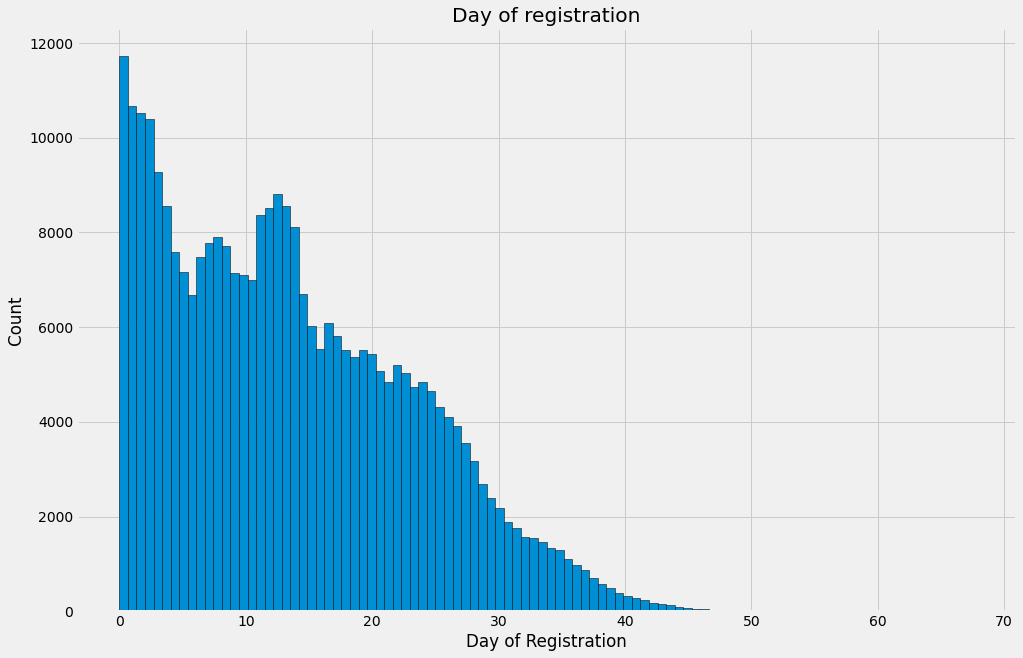

In [ ]:
# Set the style of plots
plt.figure(figsize = (15,10))
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_REGISTRATION']/-365, edgecolor = 'k', bins = 100)
plt.title('Day of registration'); plt.xlabel('Day of Registration'); plt.ylabel('Count');

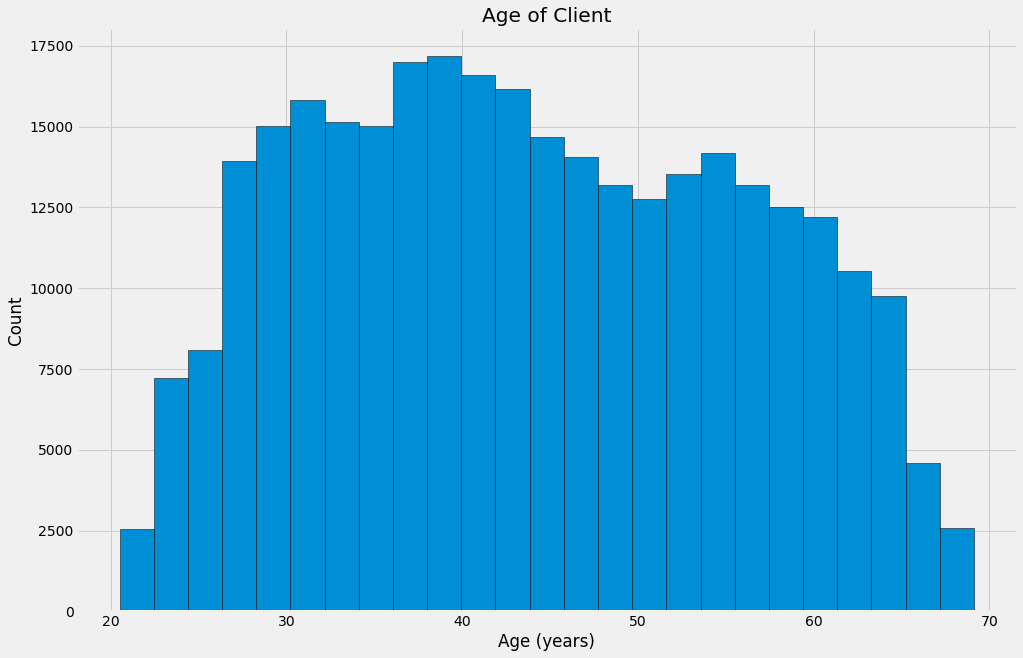

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,10))
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] /- 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

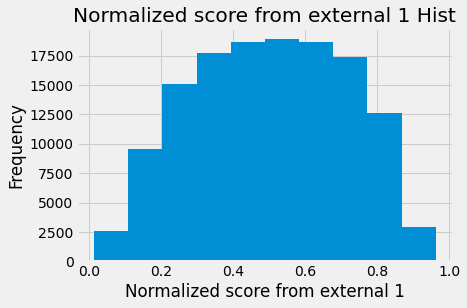

In [ ]:
create_plot_histogram(app_train,'EXT_SOURCE_1','Normalized score from external 1 Hist', 'Normalized score from external 1' )

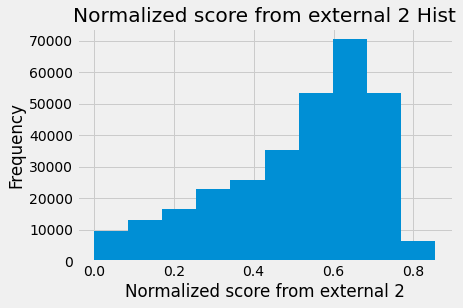

In [ ]:
create_plot_histogram(app_train,'EXT_SOURCE_2','Normalized score from external 2 Hist', 'Normalized score from external 2' )

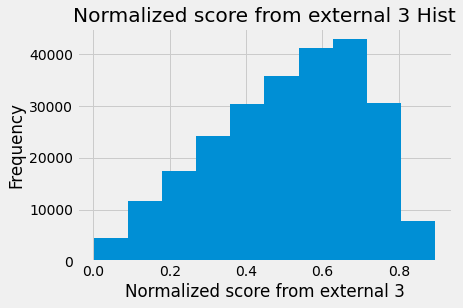

In [ ]:
create_plot_histogram(app_train,'EXT_SOURCE_3','Normalized score from external 3 Hist', 'Normalized score from external 3' )

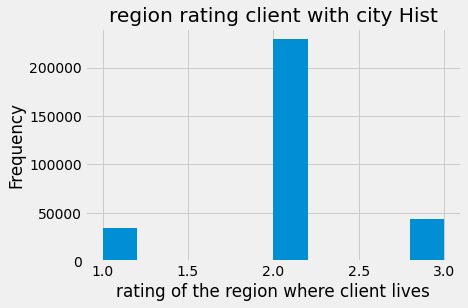

In [ ]:
create_plot_histogram(app_train,'REGION_RATING_CLIENT_W_CITY','region rating client with city Hist', 'rating of the region where client lives' )

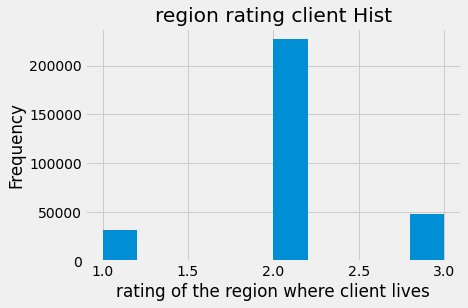

In [ ]:
create_plot_histogram(app_train,'REGION_RATING_CLIENT','region rating client Hist', 'rating of the region where client lives' )

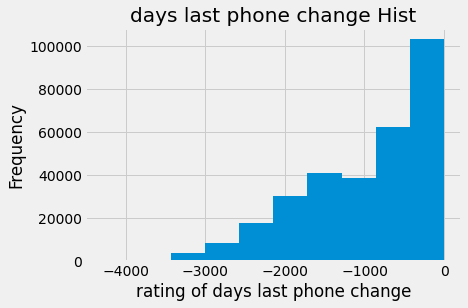

In [ ]:
create_plot_histogram(app_train,'DAYS_LAST_PHONE_CHANGE','days last phone change Hist', 'rating of days last phone change' )

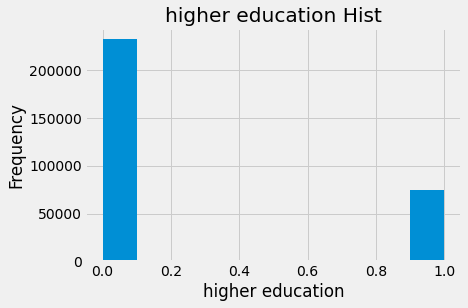

In [ ]:
create_plot_histogram(app_train_gr,'NAME_EDUCATION_TYPE_Higher education','higher education Hist', 'higher education' )

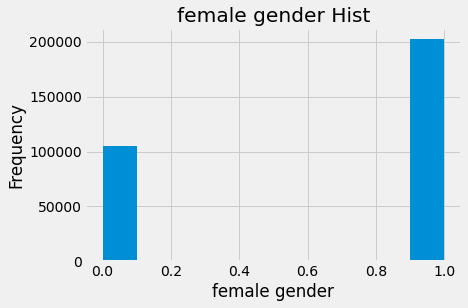

In [ ]:
create_plot_histogram(app_train,'CODE_GENDER_F','female gender Hist', 'female gender' )

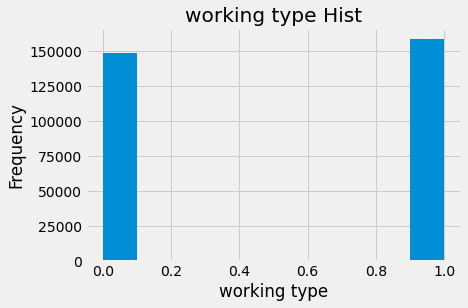

In [ ]:
create_plot_histogram(app_train,'NAME_INCOME_TYPE_Working','working type Hist', 'working type' )

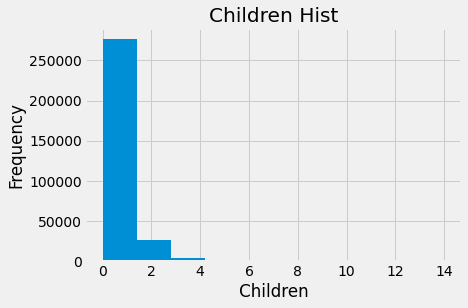

In [ ]:

# Hist với bất thường thay bằng na
app_train['CNT_CHILDREN'].replace({19: np.nan}, inplace = True)

app_train['CNT_CHILDREN'].plot.hist(title = 'Children Hist');
plt.xlabel('Children');

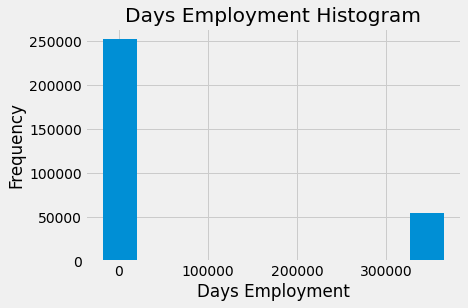

In [ ]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
create_plot_histogram(app_train,'DAYS_EMPLOYED','Days Employment Histogram', 'Days Employment' )

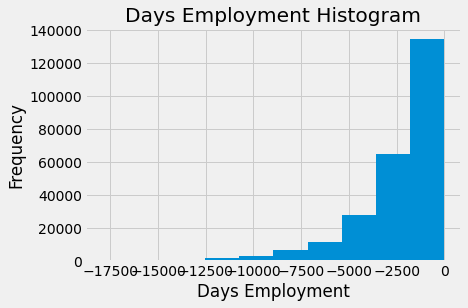

In [ ]:

# Hist với bất thường thay bằng na
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### KDE

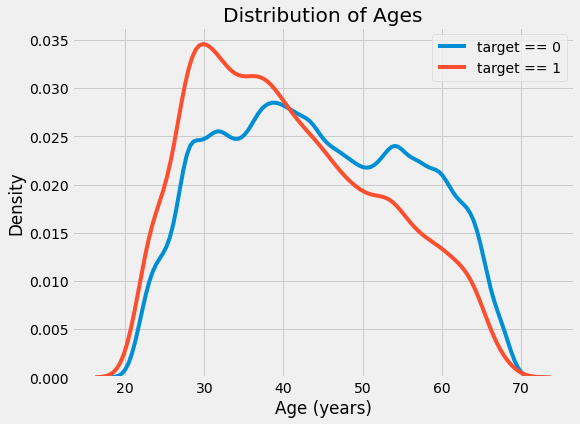

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] /- 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] /- 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

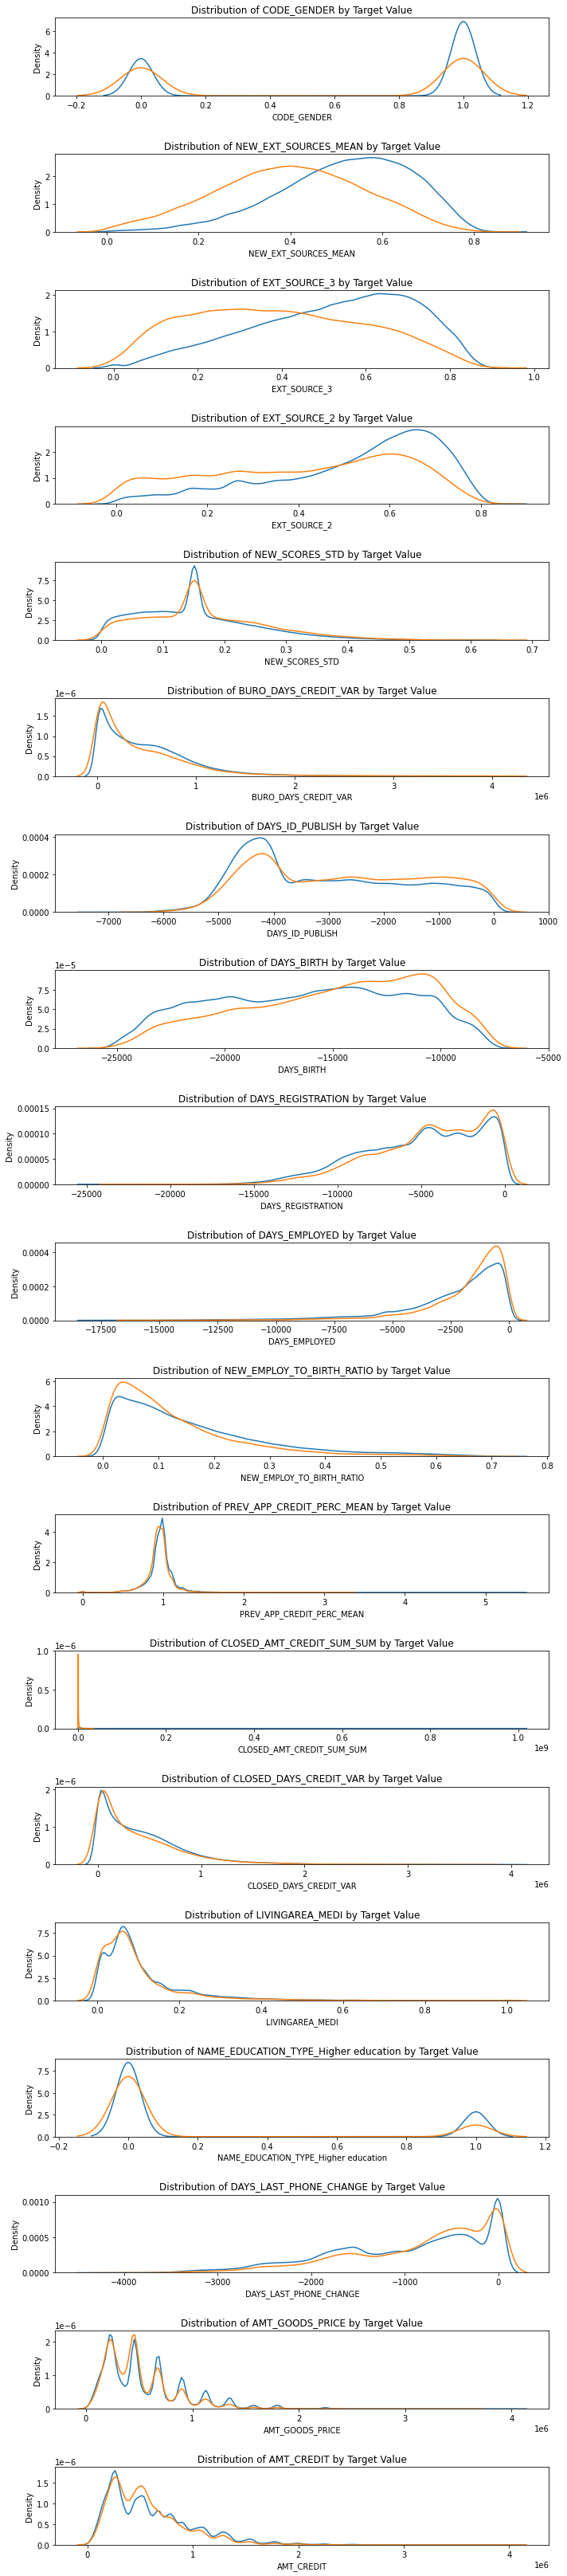

In [75]:
plt.figure(figsize = (10, 45))

# iterate through the sources
for i, source in enumerate(top_features):
    
    # create a new subplot for each source
    plt.subplot(len(top_features), 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

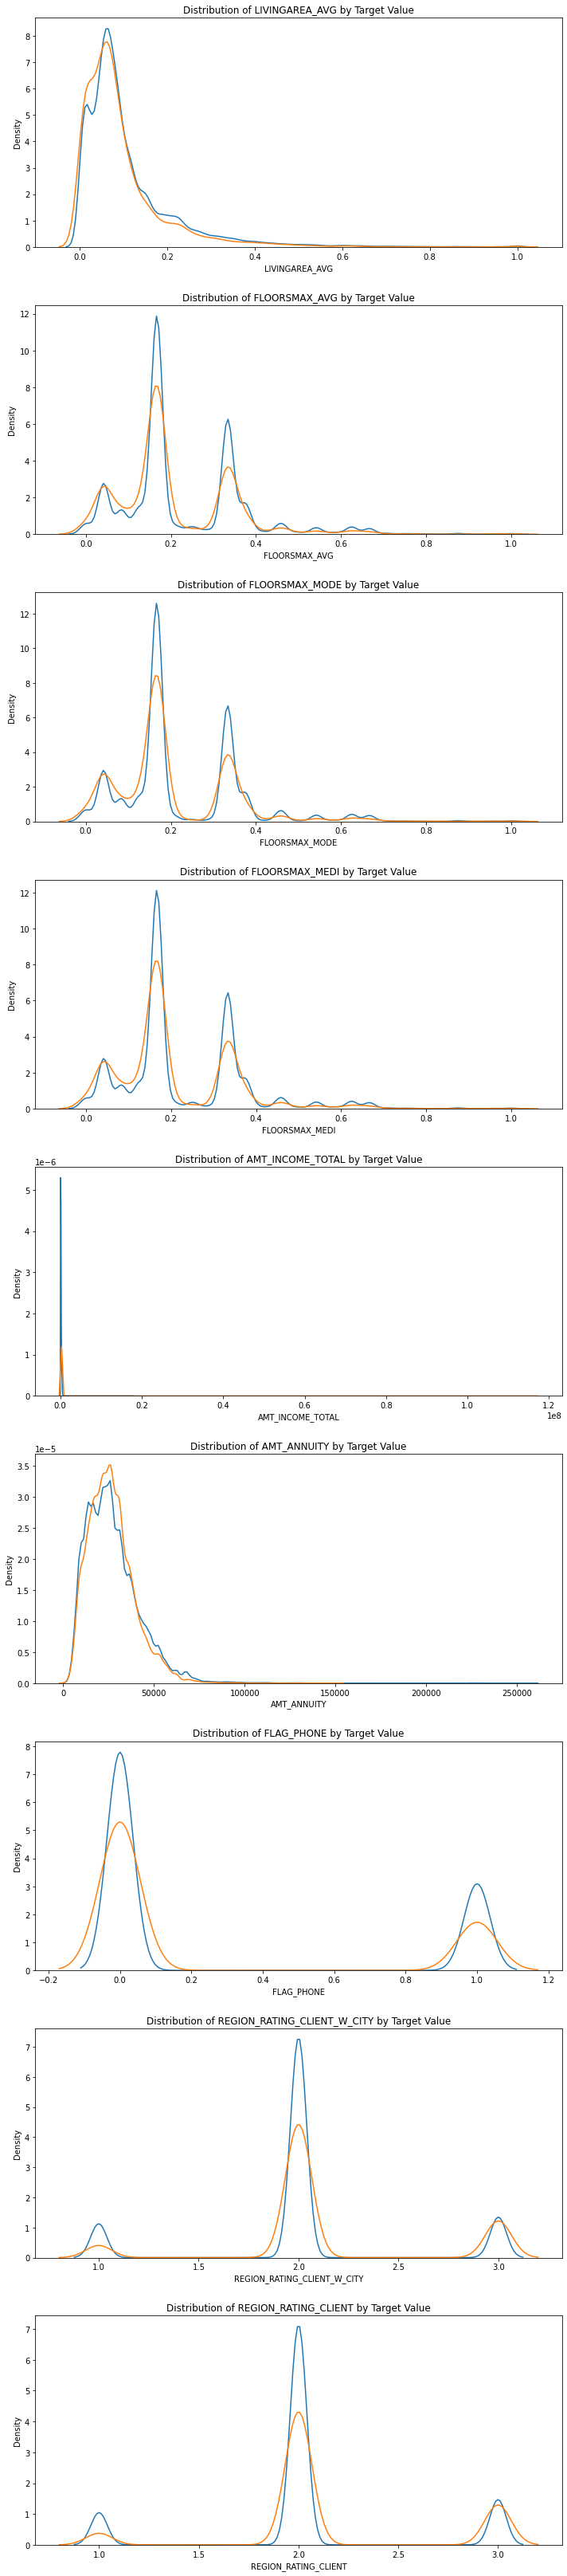

In [78]:
plt.figure(figsize = (10, 45))

# iterate through the sources
for i, source in enumerate(Sedond_features):
    
    # create a new subplot for each source
    plt.subplot(len(Sedond_features), 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
# sns.boxplot('DAYS_REGISTRATION',y='TARGET',data=app_train_test)  

In [79]:
app_train[top_features].head()

,CODE_GENDER,NEW_EXT_SOURCES_MEAN,EXT_SOURCE_3,EXT_SOURCE_2,NEW_SCORES_STD,BURO_DAYS_CREDIT_VAR,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_EMPLOYED,NEW_EMPLOY_TO_BIRTH_RATIO,PREV_APP_CREDIT_PERC_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_DAYS_CREDIT_VAR,LIVINGAREA_MEDI,NAME_EDUCATION_TYPE_Higher education,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,AMT_CREDIT
0,0,0.161787,0.139376,0.262949,0.092026,186150.000000,-2120,-9461,-3648.0,-637.0,0.067329,1.000000,383067.0,123956.700000,0.0193,0,-1134.0,351000.0,406597.5
1,1,0.466757,NaN,0.622246,0.219895,827783.583333,-291,-16765,-1186.0,-1188.0,0.070862,0.949329,207400.5,820590.333333,0.0558,1,-828.0,1129500.0,1293502.5
2,0,0.642739,0.729567,0.555912,0.122792,421362.000000,-2531,-19046,-4260.0,-225.0,0.011814,1.207699,189037.8,421362.000000,NaN,0,-815.0,135000.0,135000.0
3,1,0.650442,NaN,0.650442,0.151007,NaN,-2437,-19005,-9833.0,-3039.0,0.159905,1.010763,NaN,NaN,NaN,0,-617.0,297000.0,312682.5
4,0,0.322738,NaN,0.322738,0.151007,NaN,-3458,-19932,-4311.0,-3038.0,0.152418,0.969650,146250.0,NaN,NaN,0,-1106.0,513000.0,513000.0


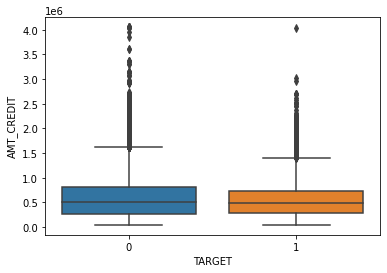

In [ ]:
# sns.boxplot(x='TARGET',y='AMT_CREDIT',data=app_train) 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'EXT_SOURCE_1')

<Figure size 1080x720 with 0 Axes>

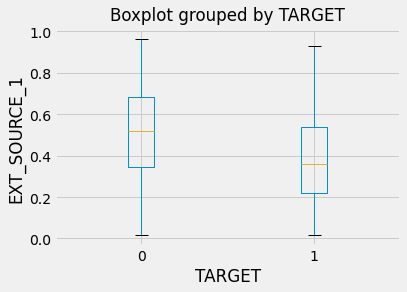

In [ ]:
plt.figure(figsize = (15,10))
app_train.boxplot(column=['EXT_SOURCE_1'], by=['TARGET'])
plt.title("")
plt.xlabel("TARGET")
plt.ylabel("EXT_SOURCE_1")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'EXT_SOURCE_2')

<Figure size 1080x720 with 0 Axes>

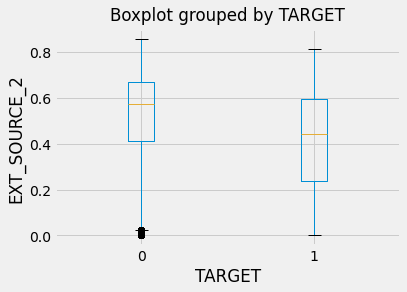

In [ ]:
plt.figure(figsize = (15,10))
app_train.boxplot(column=['EXT_SOURCE_2'], by=['TARGET'])
plt.title("")
plt.xlabel("TARGET")
plt.ylabel("EXT_SOURCE_2")


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'EXT_SOURCE_3')

<Figure size 1080x720 with 0 Axes>

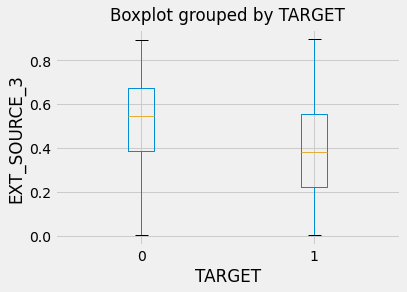

In [ ]:
plt.figure(figsize = (15,10))
app_train.boxplot(column=['EXT_SOURCE_3'], by=['TARGET'])
plt.title("")
plt.xlabel("TARGET")
plt.ylabel("EXT_SOURCE_3")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'DAYS_BIRTH')

<Figure size 1080x720 with 0 Axes>

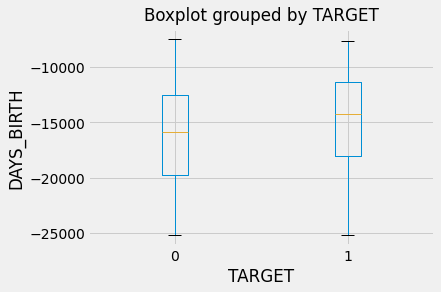

In [ ]:
plt.figure(figsize = (15,10))
app_train.boxplot(column=['DAYS_BIRTH'], by=['TARGET'])
plt.title("")
plt.xlabel("TARGET")
plt.ylabel("DAYS_BIRTH")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'DAYS_LAST_PHONE_CHANGE')

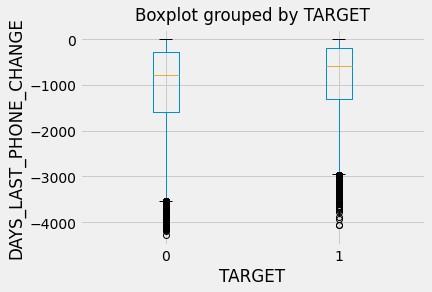

In [ ]:
app_train.boxplot(column=['DAYS_LAST_PHONE_CHANGE'], by=['TARGET'])
plt.title("")
plt.xlabel("TARGET")
plt.ylabel("DAYS_LAST_PHONE_CHANGE")

In [80]:
app_train.to_csv('new_home_credit_dataset.csv')